# UMAP MODEL 

In [1]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

from sklearn import metrics
import math

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
import umap


## DATA LOADING


This notebook goal is building a model based on UMAP dimensionallity reduction to predict the Remaining Useful Life of a certain instance.

On this purpose, first a UMAP projection is going to be built.

Once we have the projection, we apply it over the new point that we would like to predict. This point, in case that the projection results are good enough, will be near to other instances in a similar health situation.

The last step is selecting a number of "nearest neighbours", based on the two new axes, and predicting as the final outcome the remaining useful life of those. 

In [3]:
train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")


In [4]:
#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)


In [5]:
###TEST DATA SET###

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)


### DATA VECTOR PREPARATION

On this stage, I am going to prepare the data vectors that we are using as input for the UMAP projection.


In [ ]:
train_df.head()

In [6]:
train_cols = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
train_vector = train_df[train_cols]

train_vector.head()

BPR      NRc      NRf       Nc       Nf  Nf_dmd     OP1     OP2    OP3  \
0  8.4195  8138.62  2388.02  9046.19  2388.06    2388 -0.0007 -0.0004  100.0   
1  8.4318  8131.49  2388.07  9044.07  2388.04    2388  0.0019 -0.0003  100.0   
2  8.4178  8133.23  2388.03  9052.94  2388.08    2388 -0.0043  0.0003  100.0   
3  8.3682  8133.83  2388.08  9049.48  2388.11    2388  0.0007  0.0000  100.0   
4  8.4294  8133.80  2388.04  9055.15  2388.06    2388 -0.0019 -0.0002  100.0   

     P15  ...      T2     T24      T30      T50    W31      W32  epr  farB  \
0  21.61  ...  518.67  641.82  1589.70  1400.60  39.06  23.4190  1.3  0.03   
1  21.61  ...  518.67  642.15  1591.82  1403.14  39.00  23.4236  1.3  0.03   
2  21.61  ...  518.67  642.35  1587.99  1404.20  38.95  23.3442  1.3  0.03   
3  21.61  ...  518.67  642.35  1582.79  1401.87  38.88  23.3739  1.3  0.03   
4  21.61  ...  518.67  642.37  1582.85  1406.22  38.90  23.4044  1.3  0.03   

   htBleed     phi  
0      392  521.66  
1      392  522.28  
2      390  522.42  
3      392  522.86  
4      393  522.19  

[5 rows x 24 columns]

In [7]:
test_vector = test_df[train_cols]

test_vector.head()

BPR      NRc      NRf       Nc       Nf  Nf_dmd     OP1     OP2    OP3  \
0  8.4052  8125.55  2388.03  9050.17  2388.04    2388  0.0023  0.0003  100.0   
1  8.3803  8139.62  2388.06  9054.42  2388.01    2388 -0.0027 -0.0003  100.0   
2  8.4441  8130.10  2388.03  9056.96  2388.05    2388  0.0003  0.0001  100.0   
3  8.3917  8132.90  2388.05  9045.29  2388.03    2388  0.0042  0.0000  100.0   
4  8.4031  8129.54  2388.03  9044.55  2388.01    2388  0.0014  0.0000  100.0   

     P15  ...      T2     T24      T30      T50    W31      W32  epr  farB  \
0  21.61  ...  518.67  643.02  1585.29  1398.21  38.86  23.3735  1.3  0.03   
1  21.61  ...  518.67  641.71  1588.45  1395.42  39.02  23.3916  1.3  0.03   
2  21.61  ...  518.67  642.46  1586.94  1401.34  39.08  23.4166  1.3  0.03   
3  21.61  ...  518.67  642.44  1584.12  1406.42  39.00  23.3737  1.3  0.03   
4  21.61  ...  518.67  642.51  1587.19  1401.92  38.99  23.4130  1.3  0.03   

   htBleed     phi  
0      392  521.72  
1      393  522.16  
2      393  521.97  
3      391  521.38  
4      390  522.15  

[5 rows x 24 columns]

In [8]:
test_lastcycle = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
    for id in test_df['Unit'].unique()]).reset_index(drop = True)

In [9]:
RUL_test = test_lastcycle['RUL']


In [10]:
test_df[test_df['Unit']==1].tail()

Unit  Cycle     OP1     OP2    OP3      T2     T24      T30      T50  \
26     1     27 -0.0007  0.0001  100.0  518.67  642.08  1586.65  1400.31   
27     1     28  0.0022  0.0005  100.0  518.67  641.93  1594.25  1401.29   
28     1     29  0.0014  0.0001  100.0  518.67  641.95  1587.15  1398.11   
29     1     30 -0.0025  0.0004  100.0  518.67  642.79  1585.72  1400.97   
30     1     31 -0.0006  0.0004  100.0  518.67  642.58  1581.22  1398.91   

       P2  ...  htBleed  Nf_dmd  PCNfR_dmd    W31      W32  max  RUL  UL_30  \
26  14.62  ...      392    2388      100.0  38.87  23.3931  143  116      0   
27  14.62  ...      392    2388      100.0  38.83  23.3502  143  115      0   
28  14.62  ...      392    2388      100.0  39.02  23.3621  143  114      0   
29  14.62  ...      391    2388      100.0  39.09  23.4069  143  113      0   
30  14.62  ...      393    2388      100.0  38.81  23.3552  143  112      0   

    UL_50  UL_75  
26      0      0  
27      0      0  
28      0      0  
29      0      0  
30      0      0  

[5 rows x 31 columns]

## UMAP MODEL FITTING

In [11]:
train_v = (train_vector.to_numpy())
test_v = (test_lastcycle[train_cols].to_numpy())

In [12]:
print(train_v.shape, test_v.shape)

(20631, 24) (100, 24)


In [13]:
trans = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.25, metric='chebyshev').fit(train_v) # Projection calculation
train_emb = trans.embedding_ # Projection over the euclidean space
test_emb = trans.transform(test_v) # Projection test data set over the euclidean space

In [ ]:
train_df.head()

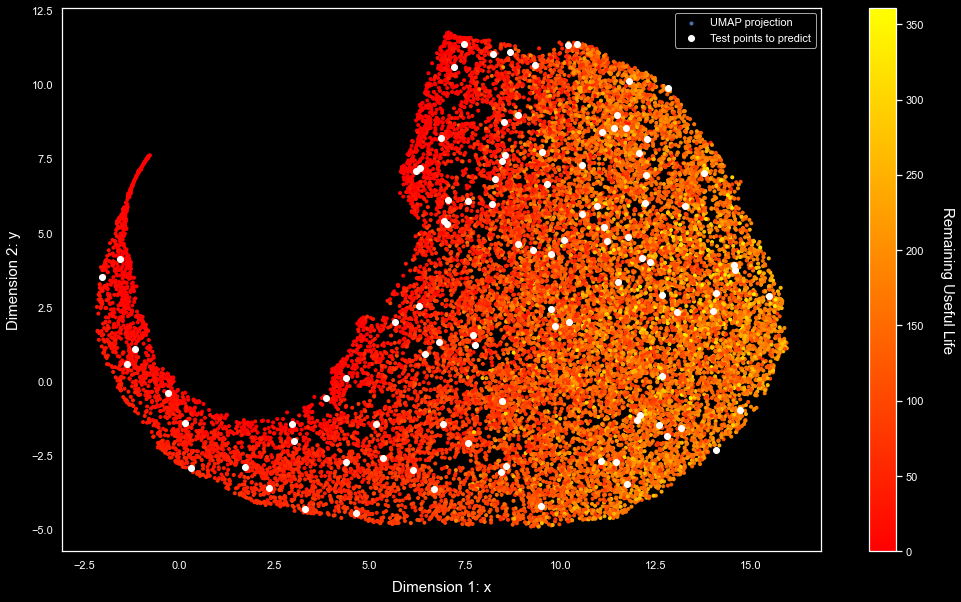

In [16]:
plt.style.use('dark_background')

fig = plt.figure(figsize = (17,10) )

ax = fig.add_subplot(111)

plot = ax.scatter(train_emb[:,0], train_emb[:,1], c = train_df['RUL'], cmap= 'autumn', marker = '.', label = 'UMAP projection')

cbar = plt.colorbar(plot)

cbar.ax.set_ylabel('Remaining Useful Life', rotation = 270, size = 15, labelpad = +30)

plot = ax.scatter(test_emb[:,0], test_emb[:,1],  color = 'white', marker = 'o', label = 'Test points to predict')

ax.set_xlabel("Dimension 1: x", size = 15, labelpad = 10)
ax.set_ylabel("Dimension 2: y", size = 15, labelpad = 10)
ax.tick_params(colors = 'white')

plt.legend()

fig.show()

In [ ]:
plt.style.use('dark_background')

fig = plt.figure(figsize = (17,10) )

ax = fig.add_subplot(111)
plot = ax.scatter(train_emb[:,0], train_emb[:,1], c = train2['UL'], cmap= 'autumn', marker = '.', label = 'Useful Lifetime')

ax.set_xlabel("Dimension 1: x", size = 15, labelpad = 10)
ax.set_ylabel("Dimension 2: y", size = 15, labelpad = 10)
ax.tick_params(colors = 'white')


cbar = plt.colorbar(plot)

cbar.ax.set_ylabel('Remaining Useful Life', rotation = 270, size = 15, labelpad = +30)




fig.show()

In [ ]:
plt.style.use('dark_background')

plt.scatter(train_emb[:,0], train_emb[:,1], c = train2['RUL_index'], cmap= 'autumn', marker = '.', label = 'Remaining Useful Index')

plt.colorbar()
plt.xticks()
plt.yticks()
plt.legend()

In [ ]:
train_df.head()

In [ ]:
RUL_train = train_df['RUL'].to_numpy()

RUL_train[RUL_train > 150] = 150

print(RUL_train.shape)

In [ ]:
NN = 20

distances = metrics.pairwise_distances(test_emb,train_emb)

RUL_predict = np.zeros(len(test_emb))
RUL_index_predict = np.zeros(len(test_emb))

for i in range(len(test_emb)):

    print('Unidad:', i)

    maxs = np.zeros(NN)

    dist = np.zeros((len(train_emb),2))
    dist[:,0] = range(len(train_emb))
    dist[:,1] = distances[i,:]

    #display(dist)
    #print(dist.shape)

    #display(np.sort(dist[:,1]))

    for j in range(NN):

        #print(np.argmin(dist[:,1]))
        #print(dist[np.argmin(dist[:,1]),1])
        

        maxs[j] = dist[np.argmin(dist[:,1]),0]

        dist = np.delete(dist, obj = np.argmin(dist[:,1]), axis = 0)
    
    RUL_predict[i] = round(np.mean(RUL_train[[maxs.astype(int)]]))

    #print("Maxs: ", maxs)
    #print(RUL_train[maxs.astype(int)])

In [ ]:
print(RUL_predict)

In [ ]:
print(RUL_predict.shape, RUL_test.to_numpy().shape)

In [ ]:
error = RUL_predict - RUL_test
abs_error = np.absolute(error)
mean_error = np.mean(abs_error)


print("Mean RUL error: " , mean_error )



In [ ]:
plt.style.use('seaborn-whitegrid')
from Perform_function import perform_func 
y_pred_test = RUL_predict
y_true_test = RUL_test

_, _, _, _, _, _ = perform_func(y_pred_test, y_true_test, test_df.groupby('Unit').max()['Cycle'].to_numpy())

In [ ]:
test_lastcycle['RUL_predict'] = RUL_predict
test_lastcycle['RUL_test'] = RUL_test.to_numpy()[:,0]
test_lastcycle['error'] = error
test_lastcycle['Absolute_error'] = abs_error
test_lastcycle['Embedding_x'] = test_emb[:,0]
test_lastcycle['Embedding_y'] = test_emb[:,1]



In [ ]:
print(test_lastcycle[test_lastcycle['Absolute_error'] > 30])
print(len(test_lastcycle[test_lastcycle['Absolute_error'] > 30]))


In [ ]:
print(error)

error.shape

In [ ]:
RUL_test

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,5))
plt.plot(range(len(test_emb)), RUL_predict, color = "#3f729a", label = 'Prediction')
plt.plot(range(len(test_emb)), RUL_test, color = "#89ce65", label = 'Real')
#plt.plot(range(len(test_emb[:130])), abs_error[:130], color = 'red', label = 'Error')

plt.ylabel('Remaining Useful Life')
plt.xlabel('Unit')

plt.xticks(range(0,100,10))

plt.legend()

In [ ]:
plt.figure(figsize = (30,5))
plt.plot(range(130, len(test_emb)), RUL_predict[130:], color = 'white', label = 'Prediction')
plt.plot(range(130, len(test_emb)), RUL_test[130:], color = 'green', label = 'Real')
plt.plot(range(130, len(test_emb)), abs_error[130:], color = 'red', label = 'Error')

plt.ylabel('Remaining Useful Life', size = 15)
plt.xlabel('Unit', size = 15)

plt.xticks(range(130,260,10))

plt.legend(fontsize = 'large')


In [ ]:
distances = metrics.pairwise_distances(test_emb,train_emb)

display(distances)

print(distances.shape)

In [ ]:
print(math.sqrt((test_emb[0,0]-train_emb[1,0])**2 + (test_emb[0,1]-train_emb[1,1])**2 ))

In [ ]:
plt.style.use('dark_background')

plt.scatter(train_emb[:,0], train_emb[:,1], c = train2['RUL_index'], cmap= 'autumn', marker = '.', label = 'Train')

plt.colorbar()
plt.scatter(test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Embedding_x'], test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Embedding_y'], c = test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Absolute_error'] , cmap = 'cool', marker= 'o')
plt.colorbar()

In [ ]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.scatter(RUL_predict, RUL_test, c = "#3f729a", marker = 'o')
ax.plot(range(200), range(200), c = 'black')

ax.set_ylabel('Real value')
ax.set_xlabel('Predicted value')

In [ ]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(RUL_predict, RUL_test[:,0], test2.groupby('Unit').max()['Cycle'].to_numpy())

In [ ]:
test2.head()

In [ ]:
print(RUL_predict.shape, RUL_test.shape)

#### SCORE METRIC

In [ ]:
s = np.zeros(len(RUL_predict))

a_1 = 10
a_2 = 13

for i in range(len(error)):

    if error[i] < 0 : 

        s[i] = math.exp(-error[i]/a_1) - 1 
    else : 
        s[i] = math.exp(error[i]/a_2) - 1

performance_evaluation = np.sum(s)

print('The model performance evaluation is:', performance_evaluation)



In [ ]:
NN = 20

distances = metrics.pairwise_distances(train_emb,train_emb)

RUL_train_predict = np.zeros(len(train_emb))
RUL_index_train_predict = np.zeros(len(train_emb))

for i in range(len(train_emb)):

    print('Unidad:', i)

    maxs = np.zeros(NN)

    dist = np.zeros((len(train_emb),2))
    dist[:,0] = range(len(train_emb))
    dist[:,1] = distances[i,:]

    #display(dist)
    #print(dist.shape)

    #display(np.sort(dist[:,1]))

    for j in range(NN):

        #print(np.argmin(dist[:,1]))
        #print(dist[np.argmin(dist[:,1]),1])
        

        maxs[j] = dist[np.argmin(dist[:,1]),0]

        dist = np.delete(dist, obj = np.argmin(dist[:,1]), axis = 0)
    
    RUL_train_predict[i] = round(np.mean(RUL_train[[maxs.astype(int)]]))

    #print("Maxs: ", maxs)
    #print(RUL_train[maxs.astype(int)])

In [ ]:
train_df['RUL_predict'] = RUL_train_predict
train_df['RUL_tuned'] = RUL_train

unit = 69

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
#ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 69 prediction")

ax.legend()


In [ ]:
train_df['RUL'] = 

In [ ]:
test_lastcycle[test_lastcycle['Absolute_error'] < 10 ]['RUL_test'].mean()

In [ ]:
def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    for i in d: 
        if i<0:
            score += (e**(-i/a1) - 1)
        else : 
            score += (e**(i/a2) - 1)
    
    return score


In [ ]:
from math import e
Computed_Score(RUL_test.to_numpy()[:,0],RUL_predict)

In [ ]:
print(RUL_test.shape,RUL_predict.shape)

In [ ]:
RUL_test.to_numpy()[:,0]

In [ ]:
error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_lastcycle[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] <= 160) & (error_df['RUL'] > 140) , 'Group_RUL'] = 8
error_df.loc[(error_df['RUL'] <= 180) & (error_df['RUL'] > 160) , 'Group_RUL'] = 9
error_df.loc[(error_df['RUL'] > 180) , 'Group_RUL'] = 10

In [ ]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

In [ ]:
error_grouped_RUL

error_df[error_df['Group_RUL']==0]

In [ ]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_axes([0,0,1,1])
ratios = ['20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,50)
plt.show()


In [ ]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '140-160']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,50)
plt.show()

In [ ]:
pd.DataFrame(y_pred_test, columns = ['RUL']).to_csv('UMAP_FD1_prediction.csv')

In [ ]:
plt.hist(test_lastcycle['RUL'])
plt.show()